<a href="https://colab.research.google.com/github/KohsukeIde/numerical-calc/blob/main/%E6%95%B0%E5%80%A4%E8%A8%88%E7%AE%97%E6%B3%95_%E8%AA%B2%E9%A1%8C14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAC法による運動量保存則の離散化

## 元の運動量保存則

非圧縮性流体の運動量保存則（Navier-Stokes方程式）:

$$
\begin{aligned}
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} &= -\frac{\partial p}{\partial x} + \nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} &= -\frac{\partial p}{\partial y} + \nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)
\end{aligned}
$$

ここで、$u$と$v$は速度成分、$p$は圧力、$\nu$は動粘性係数。

## スタガード格子構造
- $u$: $(i, j+1/2)$ に配置
- $v$: $(i+1/2, j)$ に配置
- $p$: $(i, j)$ に配置 (セル中心)

## u方向の運動量保存則の離散化

$$
\begin{aligned}
u_{i,j}^{n+1} = u_{i,j}^n + \Delta t \Big(
&-u_{i,j}^n \frac{u_{i,j}^n - u_{i,j-1}^n}{\Delta x} \\
&-\frac{1}{4} \Big[ (v_{i,j}^n + v_{i,j-1}^n) \frac{u_{i+1,j}^n - u_{i-1,j}^n}{2\Delta y} +
(v_{i-1,j}^n + v_{i-1,j-1}^n) \frac{u_{i,j}^n - u_{i-2,j}^n}{2\Delta y} \Big] \\
&-\frac{p_{i,j+1}^n - p_{i,j}^n}{\Delta x} \\
&+\nu \Big[ \frac{u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n}{\Delta x^2} +
\frac{u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n}{\Delta y^2} \Big]
\Big)
\end{aligned}
$$

## v方向の運動量保存則の離散化

$$
\begin{aligned}
v_{i,j}^{n+1} = v_{i,j}^n + \Delta t \Big(
&-\frac{1}{4} \Big[ (u_{i,j}^n + u_{i+1,j}^n) \frac{v_{i,j+1}^n - v_{i,j-1}^n}{2\Delta x} +
(u_{i,j-1}^n + u_{i+1,j-1}^n) \frac{v_{i,j}^n - v_{i,j-2}^n}{2\Delta x} \Big] \\
&-v_{i,j}^n \frac{v_{i,j}^n - v_{i-1,j}^n}{\Delta y} \\
&-\frac{p_{i+1,j}^n - p_{i,j}^n}{\Delta y} \\
&+\nu \Big[ \frac{v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j-1}^n}{\Delta x^2} +
\frac{v_{i+1,j}^n - 2v_{i,j}^n + v_{i-1,j}^n}{\Delta y^2} \Big]
\Big)
\end{aligned}
$$

## 離散化の特徴

離散化では、時間方向に前進オイラー法を使用。これは1次精度の時間積分法。高い精度が必要な場合は高次の手法（例：Runge-Kutta法）を検討する必要がある。

移流項（非線形項）には1次の風上差分を用いている。これは数値的な安定性を向上させますが、数値粘性を導入する可能性がある。

圧力勾配項には中心差分を使用。これは2次精度である。

粘性項には2次の中心差分を適用している。

スタガード格子の使用により、圧力と速度の結合を回避している。これにより、チェッカーボード不安定性を防ぎ、より安定した数値解を得ることができる。


シミュレーション開始
Step 0/100 completed


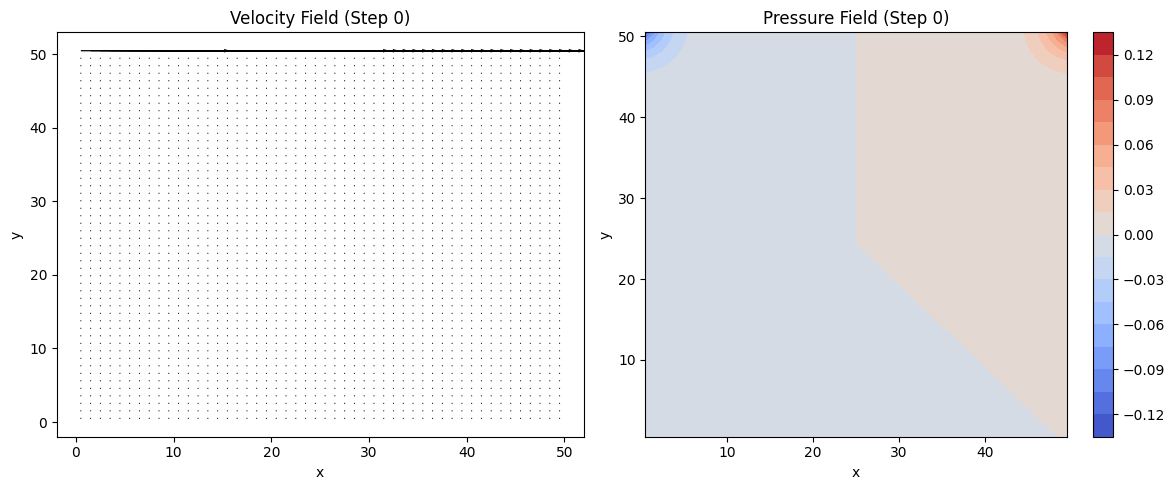

Step 20/100 completed


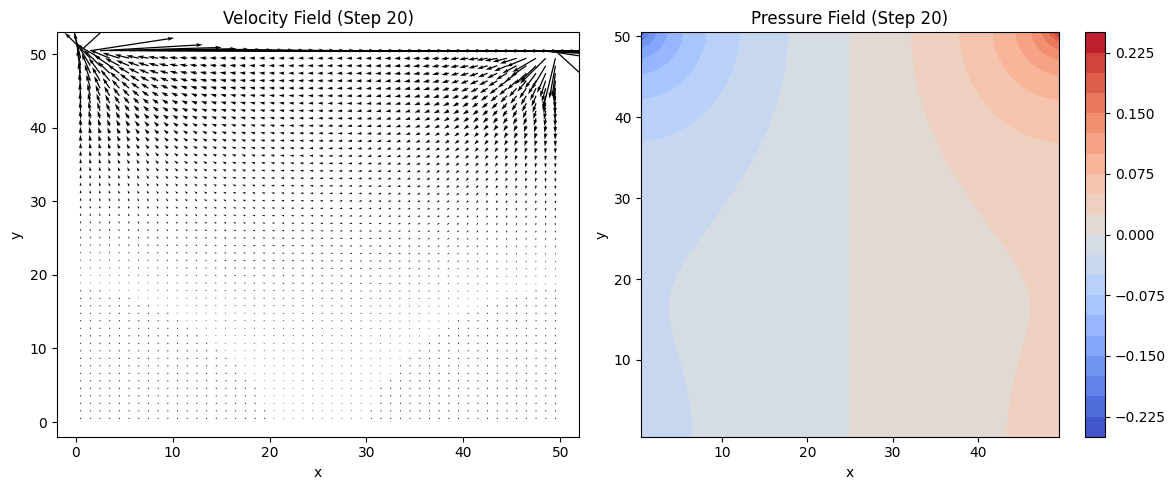

Step 40/100 completed


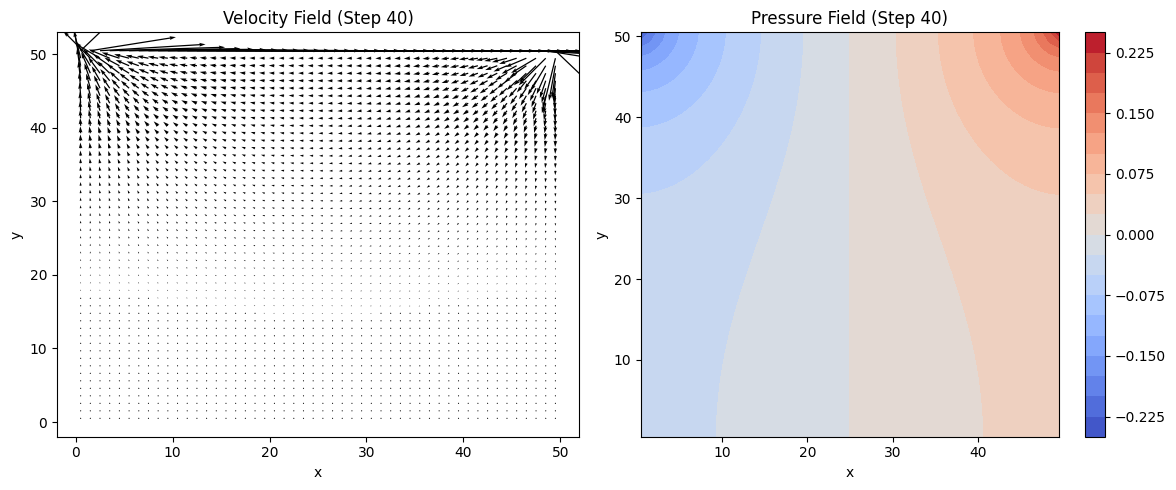

Step 60/100 completed


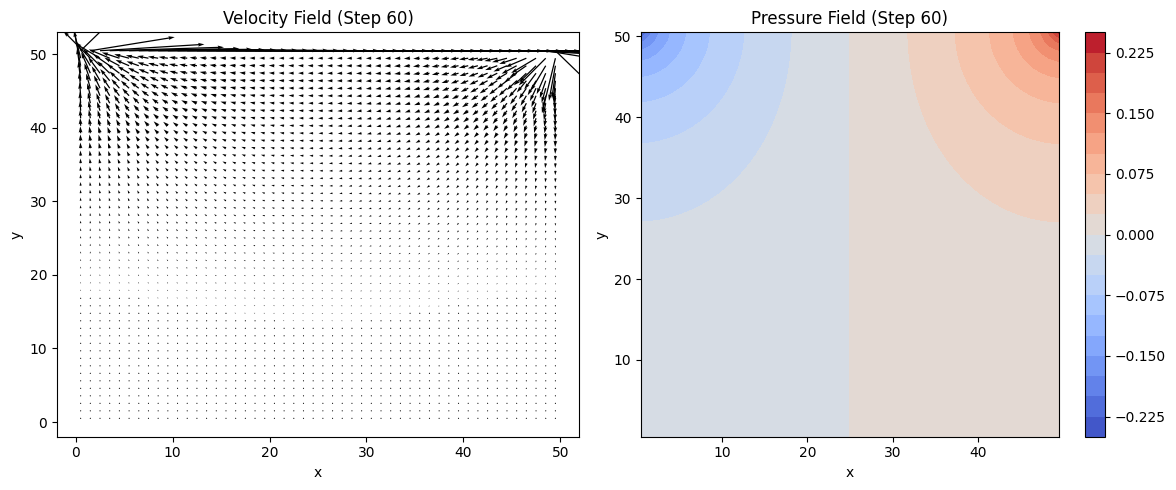

Step 80/100 completed


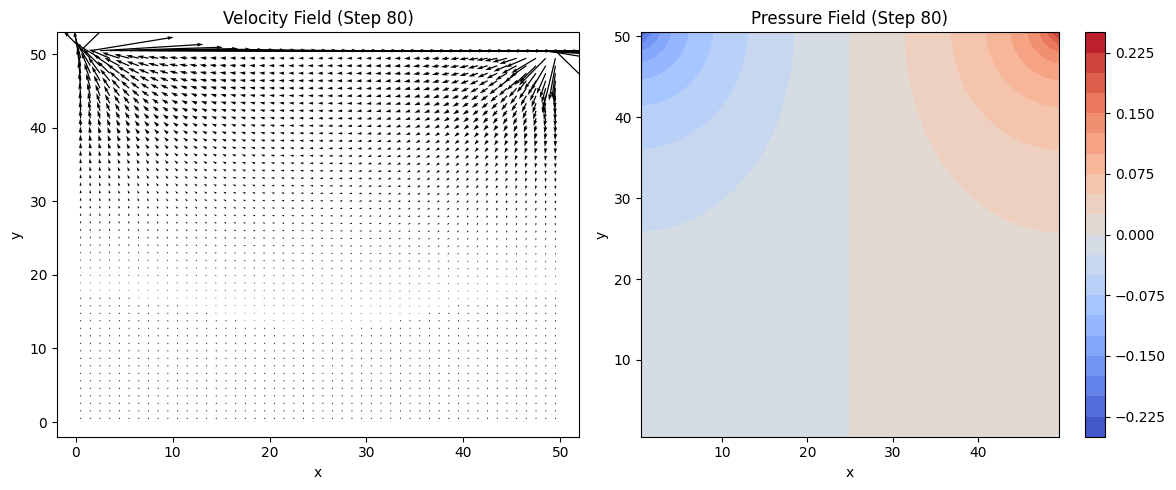

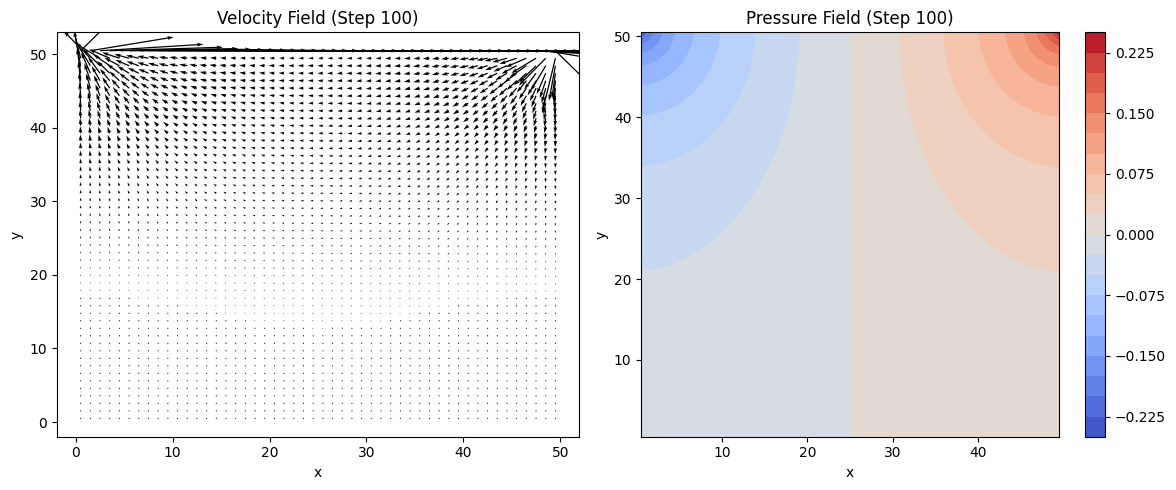

シミュレーション完了
最大発散: 0.000100


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_fields(nx, ny):
    u = np.zeros((ny+2, nx+1))
    v = np.zeros((ny+1, nx+2))
    p = np.zeros((ny+2, nx+2))
    return u, v, p

def set_boundary_conditions(u, v):
    u[-1, :] = 1  # Top wall moving right
    u[0, :] = 0   # Bottom wall
    u[:, 0] = 0   # Left wall
    u[:, -1] = 0  # Right wall
    v[0, :] = 0   # Bottom wall
    v[-1, :] = 0  # Top wall
    v[:, 0] = 0   # Left wall
    v[:, -1] = 0  # Right wall

def mac_step(u, v, p, dx, dy, dt, nu):
    ny, nx = u.shape[0]-2, u.shape[1]-1
    un = u.copy()
    vn = v.copy()

    # u-momentum equation
    for i in range(1, ny+1):
        for j in range(1, nx):
            un[i,j] = u[i,j] + dt * (
                -u[i,j] * (u[i,j] - u[i,j-1]) / dx
                -0.25 * ((v[i,j] + v[i,j-1]) * (u[i+1,j] - u[i-1,j]) / (2*dy) +
                         (v[i-1,j] + v[i-1,j-1]) * (u[i,j] - u[i-2,j]) / (2*dy))
                -(p[i,j+1] - p[i,j]) / dx
                +nu * ((u[i,j+1] - 2*u[i,j] + u[i,j-1]) / dx**2 +
                       (u[i+1,j] - 2*u[i,j] + u[i-1,j]) / dy**2)
            )

    # v-momentum equation
    for i in range(1, ny):
        for j in range(1, nx+1):
            vn[i,j] = v[i,j] + dt * (
                -0.25 * ((u[i,j] + u[i+1,j]) * (v[i,j+1] - v[i,j-1]) / (2*dx) +
                         (u[i,j-1] + u[i+1,j-1]) * (v[i,j] - v[i,j-2]) / (2*dx))
                -v[i,j] * (v[i,j] - v[i-1,j]) / dy
                -(p[i+1,j] - p[i,j]) / dy
                +nu * ((v[i,j+1] - 2*v[i,j] + v[i,j-1]) / dx**2 +
                       (v[i+1,j] - 2*v[i,j] + v[i-1,j]) / dy**2)
            )

    return un, vn

def pressure_poisson(p, u, v, dx, dy, dt, iterations=50):
    ny, nx = p.shape[0]-2, p.shape[1]-2
    for _ in range(iterations):
        pn = p.copy()
        for i in range(1, ny+1):
            for j in range(1, nx+1):
                p[i,j] = 0.25 * (pn[i+1,j] + pn[i-1,j] + pn[i,j+1] + pn[i,j-1]
                                 - dx*dy/dt * ((u[i,j] - u[i,j-1])/dx + (v[i,j] - v[i-1,j])/dy))
        p[:, 0] = p[:, 1]    # Left wall
        p[:, -1] = p[:, -2]  # Right wall
        p[0, :] = p[1, :]    # Bottom wall
        p[-1, :] = p[-2, :]  # Top wall
    return p

def simulate_flow(nx, ny, nt, dt, dx, dy, nu):
    u, v, p = initialize_fields(nx, ny)

    for n in range(nt):
        set_boundary_conditions(u, v)
        un, vn = mac_step(u, v, p, dx, dy, dt, nu)
        p = pressure_poisson(p, un, vn, dx, dy, dt)
        u, v = un, vn

        if n % 100 == 0:
            print(f"Step {n}/{nt} completed")

    return u, v, p

def visualize_results(u, v, p, dx, dy, step):
    plt.figure(figsize=(12, 5))

    # Velocity field
    plt.subplot(121)
    u_center = 0.5 * (u[1:-1, :-1] + u[1:-1, 1:])
    v_center = 0.5 * (v[:-1, 1:-1] + v[1:, 1:-1])
    x = np.linspace(dx/2, (u.shape[1]-1.5)*dx, u_center.shape[1])
    y = np.linspace(dy/2, (u.shape[0]-1.5)*dy, u_center.shape[0])
    X, Y = np.meshgrid(x, y)
    plt.quiver(X, Y, u_center, v_center)
    plt.title(f'Velocity Field (Step {step})')
    plt.xlabel('x')
    plt.ylabel('y')

    # Pressure field
    plt.subplot(122)
    plt.contourf(X, Y, p[1:-1, 1:-1], levels=20, cmap='coolwarm')
    plt.colorbar()
    plt.title(f'Pressure Field (Step {step})')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.tight_layout()
    plt.show()

def simulate_flow(nx, ny, nt, dt, dx, dy, nu, visualize_every=20):
    u, v, p = initialize_fields(nx, ny)

    for n in range(nt):
        set_boundary_conditions(u, v)
        un, vn = mac_step(u, v, p, dx, dy, dt, nu)
        p = pressure_poisson(p, un, vn, dx, dy, dt)
        u, v = un, vn

        if n % visualize_every == 0:
            print(f"Step {n}/{nt} completed")
            visualize_results(u, v, p, dx, dy, n)

    return u, v, p

# Simulation parameters
nx, ny = 50, 50
nt = 100  # Increased for better flow development
dt = 0.001
dx = dy = 1.0
nu = 0.1

print("シミュレーション開始")
u, v, p = simulate_flow(nx, ny, nt, dt, dx, dy, nu)

# Show final result
visualize_results(u, v, p, dx, dy, nt)
print("シミュレーション完了")


# 質量保存の確認
div = np.abs((u[1:-1, 1:] - u[1:-1, :-1]) / dx + (v[1:, 1:-1] - v[:-1, 1:-1]) / dy)
max_div = np.max(div)
print(f"最大発散: {max_div:.6f}")